# Semantic Code Search using Transformers and BERT - Part III
Author - Shashank Ramesh

Part-III uses docstring vectors generated by the trained ALBERT model in Part II to convert function definitions into a vectors such that they are in a shared vector space with the docstring vectors.

## Converting the functions to vectors
We have converted our docstrings to 768-dimensional vectors and next we need to convert the functions into 768-dimensional vectors such that the function vector and the docstring vector are in a shared vector space.

Transformer is widely popular due to its state-of-the-art results in the field of machine translation, hence it was decided to train the transformer model to translate functions into their English descriptions (docstrings). After training the model we would remove the decoder from the transformer architecture and use the trained encoders of the transformer to give an encoded representation of the function. This representation is further passed through LSTM and Dense layers to get the output as a 768-dimensional vector which is trained to share the vector space and be similar to docstring vector

In [1]:
#importing libraries
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
print(tf.__version__)

2.2.0


In [3]:
inp=pd.read_csv('./function_tokens.txt',names=['functions'])

In [4]:
inp.head()

,functions
0,long name type return atm
1,setupclass self self reducer reducepymatplotli...
2,main run simulation plot output
3,setupclass self self reducer reducepyckovplot
4,is host self return false


In [5]:
target=pd.read_csv('./docstrings_sorted.txt',names=['docstrings'])

In [6]:
target.head()

,docstrings
0,returns the long name type for this port
1,prepare for test by setting up worker
2,run the simulation and make a couple of plots ...
3,prepare for test by setting up worker
4,decides where to put acknowledged downtime pix...


### Translating functions to its English description (docstrings) using transformer
The transformer architecture and code which we will be using for translating our functions to docstrings is the one used in the tensorflow tutorial ‘Transformer model for language understanding’ .

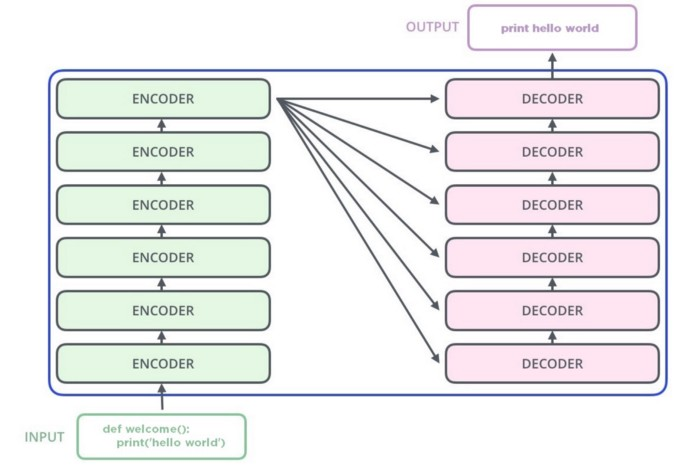

In [7]:
dataset = tf.data.Dataset.from_tensor_slices((inp.values, target.values))

In [8]:
import tokenizers

In [9]:
# We will be using the BertWordPieceTokenizer instead of the SubWordTokenizer in tensorflow

#Docstring tokenizer
tokenizer_doc = tokenizers.BertWordPieceTokenizer(
    vocab_file=None,
    strip_accents=True,
    lowercase=True,
    wordpieces_prefix='##'
)

In [10]:
#Generating the vocabulary of 30000 words from the docstrings
tokenizer_doc.train(
    files=['docstrings.txt'],
    vocab_size=30000,
    min_frequency=2,
    limit_alphabet=1000
)

In [11]:
#encoding using the docstring tokenizer
encoded = tokenizer_doc.encode('transformer is awesome')
print(encoded.ids) # Getting the ids for the docstring tokens
print(encoded.tokens) # Getting the docstring tokens

[5484, 121, 13677]
['transformer', 'is', 'awesome']


In [12]:
#saving the docstring tokenizer
tokenizer_doc.save("./", "doctring_vocab")

['./doctring_vocab-vocab.txt']

In [13]:
#Function tokenizer
tokenizer_func = tokenizers.BertWordPieceTokenizer(
    vocab_file=None,
    strip_accents=True,
    lowercase=True,
    wordpieces_prefix='##'
)

In [14]:
#Generating the vocabulary of 30000 words from the function tokens
tokenizer_func.train(
    files=['./function_tokens.txt'],
    vocab_size=30000,
    min_frequency=2,
    limit_alphabet=1000
)

In [15]:
#encoding using the function tokenizer
encoded = tokenizer_func.encode("Transformer is awesome")
print(encoded.ids)
print(encoded.tokens)

[6020, 155, 16059]
['transformer', 'is', 'awesome']


In [16]:
#saving the function tokenizer
tokenizer_doc.save("./", "function_tokens_vocab")

['./function_tokens_vocab-vocab.txt']

In [17]:
# Batch size used in our model
BATCH_SIZE = 128

In [18]:
def encode(lang1, lang2):
    # adding the [CLS] token as start token and [SEP] token as end token 

    lang1 = tokenizer_func.encode("[CLS] " + [l.decode("utf-8")  for l in lang1.numpy()][0] + " [SEP]").ids
    lang2 = tokenizer_doc.encode("[CLS] " + [l.decode("utf-8")  for l in lang2.numpy()][0] + " [SEP]").ids
  
    return lang1, lang2


def tf_encode(func, doc):
    result_func, result_doc = tf.py_function(encode, [func, doc], [tf.int64, tf.int64])
    result_func.set_shape([None])
    result_doc.set_shape([None])

    return result_func, result_doc

In [19]:
# Filter the dataset by discarding very large docstrings or functions
def filter_max_length(x, y):
    return tf.logical_and(tf.size(x) <= 300, tf.size(y) <= 50)

In [20]:
# Print values from dataset
for index,i in enumerate(dataset):
    print(i)
    if(index == 5):
        break

(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'long name type return atm'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'returns the long name type for this port'], dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'setupclass self self reducer reducepymatplotlibtester'],
      dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'prepare for test by setting up worker'], dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'main run simulation plot output'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'run the simulation and make a couple of plots showing output'],
      dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'setupclass self self reducer reducepyckovplot'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'prepare for test by setting up worker'], dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'is host self ret

In [21]:
# Create train and val dataset

train_dataset = dataset.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
print(train_dataset)

# Only pad the dataset DO NOT shuffle
train_dataset = train_dataset.padded_batch(BATCH_SIZE) #https://www.tensorflow.org/api_docs/python/tf/data/Dataset#padded_batch

#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE) 

<FilterDataset shapes: ((None,), (None,)), types: (tf.int64, tf.int64)>


In [22]:
ft_batch, en_batch = next(iter(train_dataset))
ft_batch, en_batch

(<tf.Tensor: shape=(128, 12), dtype=int64, numpy=
 array([[    2,  1426,   134, ...,     0,     0,     0],
        [    2,  8581,    84, ...,     3,     0,     0],
        [    2,  1040,   423, ...,     0,     0,     0],
        ...,
        [    2,   320,    79, ...,     0,     0,     0],
        [    2, 23829,    84, ...,     0,     0,     0],
        [    2,  1524,    84, ...,     0,     0,     0]], dtype=int64)>,
 <tf.Tensor: shape=(128, 36), dtype=int64, numpy=
 array([[   2,  163,   78, ...,    0,    0,    0],
        [   2, 2111,  105, ...,    0,    0,    0],
        [   2,  304,   78, ...,    0,    0,    0],
        ...,
        [   2,  170,   78, ...,    0,    0,    0],
        [   2, 1095,  145, ...,    0,    0,    0],
        [   2, 1477,  201, ...,    0,    0,    0]], dtype=int64)>)

5
(1, 50, 512)


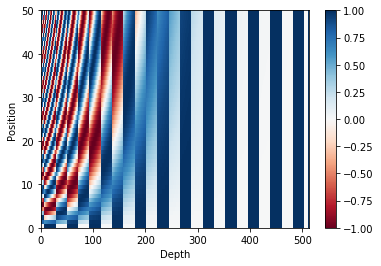

In [23]:
# Position Encoding
print(11//2) 

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates



def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)



pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [24]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [25]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

#example
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [26]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  # -1e9 ~ (-INFINITY) => where ever maks it set, make its logit value close to -INF

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [27]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

In [28]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model  # typically 512

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [29]:
def point_wise_feed_forward_network(d_model, dff): #dff =512
    return tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
          tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
      ])

In [30]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model) # with Attention

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model) #with Attention

        return out2

In [31]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
          x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'input_vocab_size':self.input_vocab_size,
            'maximum_position_encoding':self.maximum_position_encoding,
            'rate':self.rate
        })
        return config

In [32]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training,look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [33]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'target_vocab_size':self.target_vocab_size,
            'maximum_position_encoding':self.maximum_position_encoding,
            'rate':self.rate
        })
        return config

In [34]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'input_vocab_size':self.input_vocab_size,
            'target_vocab_size':self.target_vocab_size,
            'pe_input':self.pe_input,
            'pe_target':self.pe_target,
            'rate':self.rate
        })
        return config

In [35]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8


input_vocab_size = 30000
target_vocab_size = 30000
dropout_rate = 0.1

In [36]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [37]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

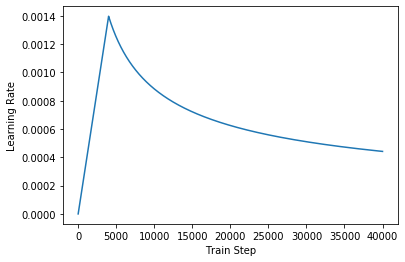

In [38]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [39]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [40]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [41]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [42]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [43]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
  
  
    
    dec_padding_mask = create_padding_mask(inp)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [44]:
checkpoint_path = "./checkpoint"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [45]:
EPOCHS = 10

In [46]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [47]:
for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()
    train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.2621 Accuracy 0.0873
Epoch 1 Batch 50 Loss 4.3135 Accuracy 0.0820
Epoch 1 Batch 100 Loss 4.3070 Accuracy 0.0808
Epoch 1 Batch 150 Loss 4.2280 Accuracy 0.0820
Epoch 1 Batch 200 Loss 4.1837 Accuracy 0.0840
Epoch 1 Batch 250 Loss 4.1427 Accuracy 0.0859
Epoch 1 Batch 300 Loss 4.1073 Accuracy 0.0871
Epoch 1 Batch 350 Loss 4.0992 Accuracy 0.0873
Epoch 1 Batch 400 Loss 4.0750 Accuracy 0.0881
Epoch 1 Batch 450 Loss 4.0615 Accuracy 0.0881
Epoch 1 Batch 500 Loss 4.0361 Accuracy 0.0890
Epoch 1 Batch 550 Loss 4.0224 Accuracy 0.0892
Epoch 1 Batch 600 Loss 4.0185 Accuracy 0.0896
Epoch 1 Batch 650 Loss 4.0122 Accuracy 0.0898
Epoch 1 Batch 700 Loss 4.0079 Accuracy 0.0897
Epoch 1 Batch 750 Loss 4.0027 Accuracy 0.0898
Epoch 1 Batch 800 Loss 3.9921 Accuracy 0.0901
Epoch 1 Batch 850 Loss 3.9750 Accuracy 0.0908
Epoch 1 Batch 900 Loss 3.9699 Accuracy 0.0913
Epoch 1 Batch 950 Loss 3.9600 Accuracy 0.0918
Epoch 1 Batch 1000 Loss 3.9556 Accuracy 0.0920
Epoch 1 Batch 1050 Loss 3.9549 Accur

In [48]:
def evaluate(inp_sentence):
  
  # inp is function tokens, adding the start and end token
    inp_sentence = tokenizer_func.encode("[CLS]"+inp_sentence+"[SEP]").ids
    encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
    decoder_input = tokenizer_doc.encode("[CLS]").ids
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(50):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == 3:
            return tf.squeeze(output, axis=0), attention_weights

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [49]:
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
  
    predicted_sentence = tokenizer_doc.decode([i for i in result 
                                            if i < 30000])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
  

### Translations made by our transformer

In [50]:
x=pd.read_csv('./function_tokens.txt',names=['functions'])
y = pd.read_csv('./docstrings.txt',names=['docstrings'])

In [51]:
translate(x['functions'][72])
print ("Real translation: ",y['docstrings'][72])

Input: open filename return file filename
Predicted translation: open a file or file like object
Real translation:  open a hdf5 file


In [52]:
translate(x['functions'][278])
print ("Real translation: ",y['docstrings'][278])

Input: num cores self raise notimplementederror
Predicted translation: returns the number of cores
Real translation:  return the number of processes


In [53]:
translate(x['functions'][2225])
print ("Real translation: ",y['docstrings'][2225])

Input: add additional operations self return
Predicted translation: add additional arguments to the list of arguments
Real translation:  add device vendor specific operations


In [54]:
translate(x['functions'][2235])
print ("Real translation: ",y['docstrings'][2235])

Input: init self none self state
Predicted translation: initialize the object
Real translation:  initialize an instance


In [55]:
translate(x['functions'][75002])
print ("Real translation: ",y['docstrings'][75002])

Input: html self return render markdown self wiki path
Predicted translation: return the html for this page
Real translation:  render the page for display


In [56]:
translate(test_df['function_tokens'][69])
print ("Real translation: ",test_df['docstring_tokens'][69])

Input: miles return miles 1 60934
Predicted translation: return a string with the given number of steps
Real translation:  converts miles to kilometers


In [57]:
translate(test_df['function_tokens'][12])
print ("Real translation: ",test_df['docstring_tokens'][12])

Input: datadir self return self subdir
Predicted translation: return the full path to the data dir
Real translation:  the directory where to save extra files


## Using transformer to generate function vectors
After the above steps we have a trained transformer which can take as input a function and translate it in English. The above task was performed by us as a precursor to our task of conversion of functions to 768-dimensional vectors. Doing so has helped us initialize our encoders weights and made them understand functions in English. This will ease the task of conversion of functions to vectors in shared vector space with the docstring vectors.

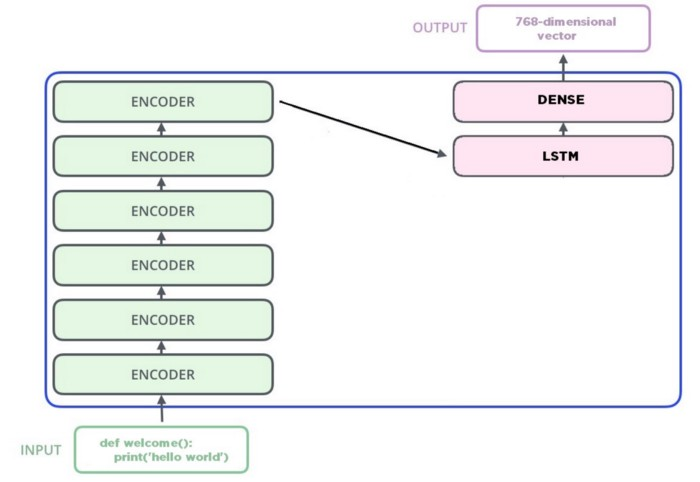

In [58]:
input_functions=pd.read_csv('./function_tokens.txt',names=['functions'])

In [59]:
import fileinput
import sys

In [60]:
from contextlib import closing

n_features = 768
def read_csv():
  # Reading multiple files using FileInput. Note the order of the input matters and it is in the order provided that files are read
  # closing ensures the file object is destroyed after use.
    with closing(fileinput.input(files=('./embeddings/avg_embeddings1.tsv', './embeddings/avg_embeddings2.tsv','./embeddings/avg_embeddings3.tsv','./embeddings/avg_embeddings4.tsv'))) as finput:
        for index,line in enumerate(finput):
            record = line.rstrip().split('\t')
            features = [float(n) for n in record]
            function = tokenizer_func.encode(input_functions['functions'].values[index]).ids
            yield function,features

def get_dataset():
    generator = lambda: read_csv()
    return tf.data.Dataset.from_generator(
        generator, (tf.int32,tf.float32), ((None,),(768)))

In [61]:
d = get_dataset()

In [62]:
# Filter the dataset by discarding very large function definitions
def filter_max_length(x, y):
    return tf.logical_and(tf.size(x) <= 300, tf.size(y) <= 1000)

In [63]:
# Create train and val dataset

train_dataset = d
train_dataset = train_dataset.filter(filter_max_length)
print(train_dataset)

BATCH_SIZE = 128
train_dataset = train_dataset.padded_batch(BATCH_SIZE,padded_shapes=((None,), (768,)))

<FilterDataset shapes: ((None,), (768,)), types: (tf.int32, tf.float32)>


5
(1, 50, 512)


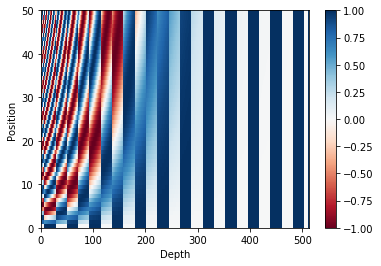

In [64]:
#Position Encoding
print(11//2) # = Floor(11/2) = 5  [Floor division in Python]

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates



def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)



pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [65]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [66]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  # -1e9 ~ (-INFINITY) => where ever maks it set, make its logit value close to -INF

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [67]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

In [68]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model  # typically 512

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [69]:
def point_wise_feed_forward_network(d_model, dff): #dff =512
    return tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
          tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
      ])

In [70]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model) # with Attention

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model) #with Attention

        return out2

In [71]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'input_vocab_size':self.input_vocab_size,
            'maximum_position_encoding':self.maximum_position_encoding,
            'rate':self.rate
        })
        return config

In [72]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [73]:
# Building our modified transformer
# We do not include the decoder layers in the transformer instead send the input from the encoder layers of the transformer 
# to an LSTM layer which passes its output to a dense layer to finally output a 768-dimensional vector
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)
        self.lstm = tf.keras.layers.LSTM(1000)
        
        self.final_layer = tf.keras.layers.Dense(768)
    
    def call(self, inp, training, enc_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        lstm_output = self.lstm(enc_output)
        final_output = self.final_layer(lstm_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output

In [74]:
sample_transformer = Transformer(num_layers=2, d_model=512, num_heads=8, dff=2048,input_vocab_size=8500,pe_input=10000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)

fn_out = sample_transformer(temp_input, training=False,enc_padding_mask=None)

fn_out.shape  # (batch_size, 768)

TensorShape([64, 768])

In [75]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8


input_vocab_size = 30000
dropout_rate = 0.1

In [76]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [77]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

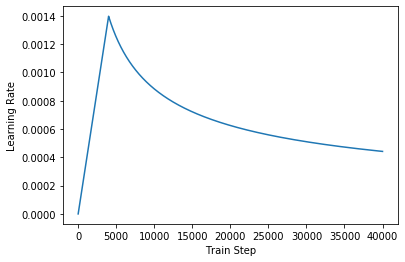

In [78]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [79]:
# we use cosine similairty as the loss we wish to optimize on
loss_object = tf.keras.losses.CosineSimilarity(axis=1)

In [80]:
# our loss function
def loss_function(real, pred):
    loss = loss_object(real, pred)

    return loss

In [81]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [82]:
modified_transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, 
                          pe_input=input_vocab_size, 
                          rate=dropout_rate)

In [83]:
# we only create the encoder mask
def create_masks(inp):
    enc_padding_mask = create_padding_mask(inp)
  
    return enc_padding_mask

In [84]:
checkpoint_path = "./final"

ckpt = tf.train.Checkpoint(modified_transformer=modified_transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [85]:
EPOCHS = 10

In [86]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.float32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    
    enc_padding_mask = create_masks(inp)
  
    with tf.GradientTape() as tape:
        predictions = modified_transformer(inp, 
                                     True, 
                                     enc_padding_mask)
        loss = loss_function(tar, predictions)

    gradients = tape.gradient(loss, modified_transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, modified_transformer.trainable_variables))
  
    train_loss(loss)

In [87]:
# Transferring encoder weights from the transformer trained on translation of functions to english to the encoders of 
# the modified transformer 
modified_transformer.layers[0].set_weights(transformer.layers[0].get_weights())

In [88]:
# Freeze the encoder layers and train the LSTM and dense layers only
# Then train the entire architecture by setting trainable to true and beginning training
modified_transformer.layers[0].trainable = False

In [89]:
for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()
  
  # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, train_loss.result()))
      
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), ))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss -0.9100
Epoch 1 Batch 50 Loss -0.8978
Epoch 1 Batch 100 Loss -0.8962
Epoch 1 Batch 150 Loss -0.8989
Epoch 1 Batch 200 Loss -0.9003
Epoch 1 Batch 250 Loss -0.9012
Epoch 1 Batch 300 Loss -0.9019
Epoch 1 Batch 350 Loss -0.9020
Epoch 1 Batch 400 Loss -0.9025
Epoch 1 Batch 450 Loss -0.9030
Epoch 1 Batch 500 Loss -0.9037
Epoch 1 Batch 550 Loss -0.9038
Epoch 1 Batch 600 Loss -0.9043
Epoch 1 Batch 650 Loss -0.9035
Epoch 1 Batch 700 Loss -0.9034
Epoch 1 Batch 750 Loss -0.9035
Epoch 1 Batch 800 Loss -0.9039
Epoch 1 Batch 850 Loss -0.9042
Epoch 1 Batch 900 Loss -0.9043
Epoch 1 Batch 950 Loss -0.9046
Epoch 1 Batch 1000 Loss -0.9046
Epoch 1 Batch 1050 Loss -0.9047
Epoch 1 Batch 1100 Loss -0.9051
Epoch 1 Batch 1150 Loss -0.9061
Epoch 1 Batch 1200 Loss -0.9075
Epoch 1 Batch 1250 Loss -0.9080
Epoch 1 Batch 1300 Loss -0.9079
Epoch 1 Batch 1350 Loss -0.9078
Epoch 1 Batch 1400 Loss -0.9078
Epoch 1 Batch 1450 Loss -0.9078
Epoch 1 Batch 1500 Loss -0.9077
Epoch 1 Batch 1550 Loss -0.9079

In [90]:
# generate embeddings for the functions without docstrings
def generate_embeddings(inp_sentence):
    encoder_input = tf.expand_dims(inp_sentence, 0) # Create input with batch size 1
    enc_padding_mask, = create_masks(encoder_input) # Create encoder mask
    predictions = modified_transformer(encoder_input,False,enc_padding_mask) # Get the function vector
    return predictions[0].numpy() # Convert the function vector to numpy array and return

In [91]:
inp = tokenizer_func.encode(test_df['function_tokens'][0]).ids
generate_embeddings(inp)

array([-3.4452100e+00, -1.6166962e+00, -4.2620835e+00, -1.0503544e+00,
       -8.3090311e-01, -3.8464019e+00,  1.4537885e-03, -3.7522993e+00,
       -8.1094770e+00, -1.4276340e+00, -1.8953466e+00, -3.1414649e+00,
        3.2484522e+00, -1.7434863e+00, -2.1018672e+00,  4.0619907e+00,
       -3.4790761e+00,  3.7852559e+00, -2.8715425e+00, -1.5058489e+00,
        9.0131474e+00, -1.6045312e+00,  4.3589411e+00, -4.3318820e+00,
        1.4809724e+00,  1.3228540e+00,  1.6325223e+00,  8.7626066e+00,
        1.7716136e+00, -7.2315234e-01,  1.6628670e+00,  1.8392999e+00,
        1.7301327e+00, -3.8438978e+00, -4.9710717e+00, -3.4457712e+00,
       -5.7400069e+00, -2.2128651e+00,  1.3614750e+00,  3.5416210e+00,
       -1.3140559e+00,  2.5987954e+00, -4.3814559e+00,  7.6627356e-01,
       -6.4936006e-01,  7.8268689e-01,  8.7989849e-01,  2.9721913e+00,
        4.1647363e+00,  1.4678499e+00, -8.8057923e-01, -5.3648818e-01,
        1.6133127e+00, -8.1666756e+00, -4.4643288e+00,  5.5573740e+00,
      

In [92]:
without_docstrings = pd.read_csv('without_docstrings.csv')

In [93]:
without_docstrings.head()

,Unnamed: 0,nwo,path,function_name,lineno,original_function,function_tokens,docstring_tokens,url
0,0,fnl/libfnl,src/fnl/nlp/dictionary.py,__init__,19,"def __init__(self, *leafs, **edges):\r\n se...",init self leafs edges self edges edges self le...,NaN,https://github.com/fnl/libfnl/blob/master/src/...
1,1,fnl/libfnl,src/fnl/nlp/dictionary.py,__eq__,23,"def __eq__(self, other):\r\n if isinstance(...",eq self other if isinstance other node return ...,NaN,https://github.com/fnl/libfnl/blob/master/src/...
2,2,fnl/libfnl,src/fnl/nlp/dictionary.py,__repr__,29,def __repr__(self):\r\n return 'Node<leafs=...,repr self return node leafs edges format self ...,NaN,https://github.com/fnl/libfnl/blob/master/src/...
3,10,fnl/libfnl,src/fnl/nlp/dictionary.py,_isCapitalized,170,@staticmethod\r\ndef _isCapitalized(token):\r\...,iscapitalized token return len token 1 and tok...,NaN,https://github.com/fnl/libfnl/blob/master/src/...
4,11,fnl/libfnl,src/fnl/nlp/dictionary.py,_isCapitalizeD,175,"@staticmethod\r\ndef _isCapitalizeD(last, toke...",iscapitalized last token return last and len t...,NaN,https://github.com/fnl/libfnl/blob/master/src/...


In [94]:
func_vector = []
for i in range(len(without_docstrings['function_tokens'].values)):
    inp = tokenizer_func.encode(test_df['function_tokens'][i]).ids # Encode the function tokens
    func_vector.append(generate_embeddings(inp)) # Store the list of function vectors

import csv
# Store the fucntion vectors in a .tsv file
with open("func_vectors.tsv","w+",newline='') as my_csv:
    csvWriter = csv.writer(my_csv,delimiter='\t')
    csvWriter.writerows(func_vector)

## Creating the semantic search engine
Its time to put our model trained to generate function vectors to test by searching through the vectors generated to find results intended by the search query.

In [95]:
# Load the ALBERT model to convert the query into a vector
from transformers import AlbertTokenizer, TFAlbertModel

albert_tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2") 

from transformers import  AlbertConfig

config = AlbertConfig.from_pretrained('./albert', output_hidden_states=True)

model = TFAlbertModel.from_pretrained('./albert', config=config,  from_pt=True)

In [96]:
import nmslib
# We initliaze values to use Hierarchial Navigable Small Worlds (hnsw) and Cosine similarity as the distance metric
search_index = nmslib.init(method='hnsw', space='cosinesimil') 
e = np.loadtxt('func_vectors.tsv',delimiter='\t') # Load our saved fucntion vectors
search_index.addDataPointBatch(e) 
search_index.createIndex(print_progress=True) # Create our search indices

In [97]:
def search(query):
    e = albert_tokenizer.encode(query, max_length=512) # Use our trained ALBERT model to generate query vector
    input = tf.constant(e)[None, :]  # Batch size 1 
    output = model(input)
    v = [0]*768
    for i in range(1, len(input[0])-1):
        v = v + output[0][0][i].numpy()  
    emb = v/len(input[0]) # Generate query vector
    
    # Search five nearest neighbours, their index value and cosine distances are returned
    idxs, dists = search_index.knnQuery(emb, k=5) 

    # Function details for the index value returned are extracted and printed
    for idx, dist in zip(idxs, dists):
            code = without_docstrings['original_function'][idx]  
            url = without_docstrings['url'][idx]
            print(f'cosine dist:{dist:.4f} \n {url}  \n {code} \n---------------------------------\n')

In [98]:
search_index.saveIndex('./final.nmslib') # Save the search indices

In [99]:
search_index.loadIndex('./final.nmslib') # Load the index

In [100]:
search('check if process is alive') # Search

cosine dist:0.0053  
https://github.com/veegee/amqpy/blob/master/amqpy/transport.py#L243 
 def is_alive(self):
         if not self.sock:
        return False
    if not self.connected:
        return False
    try:
        self.send_heartbeat()
    except socket.error:
        return False
    return True
 
---------------------------------

cosine dist:0.0120  
https://github.com/cisco-sas/kitty/blob/master/kitty/monitors/base.py#L66 
 def _is_alive(self):
         if self.monitor_thread is not None:
        if self.monitor_thread.is_alive():
            return True
    return False
 
---------------------------------

cosine dist:0.0180  
https://github.com/zuBux/drydock/blob/master/audits/audit.py#L94 
 def process_running(self, proc_name):
         procs = psutil.process_iter()
    for proc in procs:
        if proc.name() == proc_name:
            cmd = proc.cmdline()
            return cmd
    logging.error('No process named %s.Are you sure %s is running?' % (
        proc_name,